Loading packages

In [1]:
import cv2
import numpy as np
import math
import pywt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from skimage.metrics import structural_similarity as ssim


Helper functions for working with images

In [2]:
def load_image(image_path):
    img = mpimg.imread(image_path)
    img_gray = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
    return img_gray

def add_noise(image, sigma):
    noise = np.random.normal(0, sigma, image.shape)
    noisy_image = image + noise
    return (noisy_image)

def display(image, title=""):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def save_image(image_array, path):
    plt.imsave(path, image_array, cmap='gray')
  

This next chunk has the implementations for DWT, IDWT and the thresholding function

    1. decomposition function - decomposes the image into wavelet coefficients

    2. thresholding function - applies the threshold value with a given mode (hard/soft)

    3. reconstruction function - uses IDWT to reconstruct the denoised image

In [3]:
#1. Wavelet Decomposition

def wavelet_decompose(img, wavelet, level=3):
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level, mode='periodization')
    cA = coeffs[0]
    detail_levels = coeffs[1:]  # list of (cH, cV, cD)
    return cA, detail_levels

#2. Thresholding

def threshold_coeffs(detail_levels, threshold, mode):
    thresholded_details = []
    for cH, cV, cD in detail_levels:
        cH_thresh = pywt.threshold(cH, threshold, mode=mode)
        cV_thresh = pywt.threshold(cV, threshold, mode=mode)
        cD_thresh = pywt.threshold(cD, threshold, mode=mode)
        thresholded_details.append((cH_thresh, cV_thresh, cD_thresh))

    return thresholded_details

#3. Reconstructing the Image

def reconstruct_from_coeffs(cA, detail_levels, wavelet):
    coeffs = [cA] + detail_levels
    return pywt.waverec2(coeffs, wavelet=wavelet, mode='periodization')

This section: Thresholding strategies for a known sigma value. 
Computes both sure and universal in one function. the universal value is used to put an upper bound on the search space for the SURE value to speed up runtime

In [4]:



def compute_thresholds(coeffs, sigma, n_points=200):
    x = coeffs.flatten()
    n = x.size
    abs_x = np.abs(x)
    
    # Universal threshold
    T_univ = sigma * np.sqrt(2 * np.log(n))
    
    # Choose an upper bound for SURE threshold for efficiency
    max_coeff = np.max(abs_x)
    upper_bound = max(T_univ*1.5, max_coeff*0.5)  
    thresholds = np.linspace(0.01, upper_bound, n_points)
    
    # Compute SURE risk for each threshold
    risks = []
    for t in thresholds:
        count = np.sum(abs_x <= t)
        min_terms = np.minimum(abs_x**2, t**2)
        risk = n * sigma**2 - 2 * sigma**2 * count + np.sum(min_terms)
        risks.append(risk)
    
    risks = np.array(risks)
    
    # Find optimal threshold
    idx_min = np.argmin(risks)
    SURE_threshold = thresholds[idx_min]  
    
    return T_univ, SURE_threshold


#univ,sure = compute_thresholds(all_detail_flat, sigma=50, n_points=200)

This section: Performance Metrics. 

    1.creates a binary mask to use for 4.
    
    2. computes PSNR

    3. computes SSIM

    4. computes Masked SSIM

In [ ]:
# this chunk makes the binary mask and is ran once only for the purpose of creating a mask for the simulation study. fill_all_holes had to be used a number of times 
# to remove the black space in the ROI without altering the edges.

def threshold_mask2(img, threshold):
    img_uint8 = img.astype(np.uint8)
    _, thresh = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    
    return thresh

def fill_all_holes(binary_mask, kernel_size=5):
    mask = binary_mask.copy().astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return closed


img = load_image('small_image/Te-gl_0038.jpg')
thresholded_mask = threshold_mask2(img, threshold=15)
flood = fill_all_holes(thresholded_mask, kernel_size=10)
flood2 = fill_all_holes(flood, kernel_size=15)
binary_mask = fill_all_holes(flood2, kernel_size=30)
#save_image(binary_mask, 'binary_mask.png')


In [6]:
# PSNR Calculation

def compute_psnr(original, denoised, max_pixel=255.0):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')  # Perfect match
    psnr = 10 * np.log10((max_pixel ** 2) / mse)

    return psnr

# SSIM Calculation

def compute_ssim(img1, img2):
    _,score= ssim(img1, img2,data_range=255, full=True)
    return np.mean(score)

# Masked SSIM Calculation

def masked_ssim(img1, img2, mask):
    mask = (mask > 0)
    # Compute full SSIM map
    _, ssim_map = ssim(img1, img2, data_range=255, full=True)
    # Average SSIM over masked region
    masked_score = np.mean(ssim_map[mask])
    return masked_score


Demonstration

Simulation study: use all previously defined functions to do the following:

    1. load clean image and add the noise

    2. choose wavelet family & decompose

    3. compute threshold values: universal and SURE 

    4. threshold & reconstruct using hard & soft

    5. compute PSNR

    6. compute SSIM

    7. compute MSSIM

In [37]:
import numpy as np
import pandas as pd

def compare_wavelet_families(image_path, noise_sigma=20, wavelets=['sym4', 'db4', 'coif3', 'bior1.3']):
    """
    Compare different wavelet families for image denoising.
    
    Parameters:
    -----------
    image_path : str
        Path to the clean test image
    noise_sigma : float
        Standard deviation of noise to add
    wavelets : list
        List of wavelet names to compare
    
    Returns:
    --------
    results_df : pandas.DataFrame
        DataFrame with wavelet performance comparison
    """
    
    print(f"Comparing wavelet families for denoising (σ = {noise_sigma})")
    print(f"Wavelets to test: {wavelets}")
    
    # Load clean image
    clean_img = load_image(image_path)
    
    # Add noise once for consistent comparison
    noisy_img = add_noise(clean_img, sigma=noise_sigma)
    
    # Initialize results storage - FIXED: Consistent column names
    results = {
        'Wavelet': [],
        'SURE (soft) (dB)': [],
        'Universal (soft) (dB)': [],
        'SURE (hard) (dB)': [],
        'Universal (hard) (dB)': []
    }
    
    print("\nProcessing wavelets...")
    
    for wavelet in wavelets:
        try:
            print(f"  Testing {wavelet}...")
            
            # Wavelet decomposition
            cA, detail_levels = wavelet_decompose(noisy_img, wavelet=wavelet, level=3)
            
            # Flatten detail coefficients for threshold computation
            detail_flat = np.concatenate([coeff.ravel() for level in detail_levels for coeff in level])
            
            # Compute thresholds
            T_univ, sure_threshold = compute_thresholds(detail_flat, sigma=noise_sigma, n_points=200)
            
            # Apply SURE threshold with soft thresholding
            thresholded_details_sure = threshold_coeffs(detail_levels, sure_threshold, mode='soft')
            denoised_img_sure = reconstruct_from_coeffs(cA, thresholded_details_sure, wavelet=wavelet)
            
            # Apply SURE threshold with hard thresholding
            h_thresholded_details_sure = threshold_coeffs(detail_levels, sure_threshold, mode='hard')
            h_denoised_img_sure = reconstruct_from_coeffs(cA, h_thresholded_details_sure, wavelet=wavelet)
            
            # Apply Universal threshold with soft thresholding
            thresholded_details_univ = threshold_coeffs(detail_levels, T_univ, mode='soft')
            denoised_img_univ = reconstruct_from_coeffs(cA, thresholded_details_univ, wavelet=wavelet)

            # Apply Universal threshold with hard thresholding
            h_thresholded_details_univ = threshold_coeffs(detail_levels, T_univ, mode='hard')
            h_denoised_img_univ = reconstruct_from_coeffs(cA, h_thresholded_details_univ, wavelet=wavelet)
            
            # Compute performance metrics
            psnr_sure = compute_psnr(clean_img, denoised_img_sure, max_pixel=255.0)
            h_psnr_sure = compute_psnr(clean_img, h_denoised_img_sure, max_pixel=255.0)
            psnr_univ = compute_psnr(clean_img, denoised_img_univ, max_pixel=255.0)
            h_psnr_univ = compute_psnr(clean_img, h_denoised_img_univ, max_pixel=255.0)
            
            # Store results - FIXED: Match column names
            results['Wavelet'].append(wavelet)
            results['SURE (soft) (dB)'].append(round(psnr_sure, 2))
            results['Universal (soft) (dB)'].append(round(psnr_univ, 2))
            results['SURE (hard) (dB)'].append(round(h_psnr_sure, 2))
            results['Universal (hard) (dB)'].append(round(h_psnr_univ, 2))
            
        except Exception as e:
            print(f"  Error with {wavelet}: {str(e)}")
            # Store NaN values for failed cases
            results['Wavelet'].append(wavelet)
            results['SURE (soft) (dB)'].append(np.nan)
            results['SURE (hard) (dB)'].append(np.nan)
            results['Universal (soft) (dB)'].append(np.nan)
            results['Universal (hard) (dB)'].append(np.nan)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by SURE soft PSNR (best first) - FIXED: Use correct column name
    results_df = results_df.sort_values('SURE (soft) (dB)', ascending=False).reset_index(drop=True)
    
    # Display results
    print("\n" + "="*80)
    print("WAVELET FAMILY COMPARISON RESULTS")
    print("="*80)
    print(f"Noise level: σ = {noise_sigma}")
    print(f"Thresholding: SURE vs Universal threshold, soft and hard thresholding")
    print(f"Decomposition: 3 levels")
    print("-"*80)
    
    # Print the table
    print(results_df.to_string(index=False))
    
    # ADDED: Print DataFrame and LaTeX table
    print("\nDataFrame:")
    print(results_df)
    
    print("\nLaTeX table:")
    latex_table = results_df.to_latex(index=False, float_format='%.2f', escape=False)
    print(latex_table)
    
    return results_df

def extended_wavelet_comparison(image_path, noise_sigma=20):
    """
    Extended comparison including more wavelet families.
    """
    
    extended_wavelets = [
        'sym4', 'sym8', 'sym12',
        'db4', 'db8', 'db12', 
        'coif2', 'coif3', 'coif5',
        'bior1.1', 'bior1.3', 'bior2.2'
    ]
    
    print("Running extended wavelet comparison...")
    results_df = compare_wavelet_families(image_path, noise_sigma, extended_wavelets)
    
    # ADDED: Print extended results and LaTeX
    print("\nExtended DataFrame:")
    print(results_df)
    
    print("\nExtended LaTeX table:")
    latex_table = results_df.to_latex(index=False, float_format='%.2f', escape=False)
    print(latex_table)
    
    return results_df


    # For extended comparison:
extended_results = extended_wavelet_comparison('small_image/Te-gl_0038.jpg', noise_sigma=20)

Running extended wavelet comparison...
Comparing wavelet families for denoising (σ = 20)
Wavelets to test: ['sym4', 'sym8', 'sym12', 'db4', 'db8', 'db12', 'coif2', 'coif3', 'coif5', 'bior1.1', 'bior1.3', 'bior2.2']

Processing wavelets...
  Testing sym4...
  Testing sym8...
  Testing sym12...
  Testing db4...
  Testing db8...
  Testing db12...
  Testing coif2...
  Testing coif3...
  Testing coif5...
  Testing bior1.1...
  Testing bior1.3...
  Testing bior2.2...

WAVELET FAMILY COMPARISON RESULTS
Noise level: σ = 20
Thresholding: SURE vs Universal threshold, soft and hard thresholding
Decomposition: 3 levels
--------------------------------------------------------------------------------
Wavelet  SURE (soft) (dB)  Universal (soft) (dB)  SURE (hard) (dB)  Universal (hard) (dB)
  coif5             31.52                  29.16             26.24                  30.49
  sym12             31.51                  29.10             26.23                  30.44
   sym8             31.46         

In [ ]:
# now we have chosen the best wavelet and thresholding method. time to make some pictures. 

img = load_image('small_image/Te-gl_0038.jpg')
noisy_img = add_noise(img, sigma=20)
#save_image(noisy_img, 'simulation/noisy_image.png')
cA, detail_levels = wavelet_decompose(noisy_img, wavelet='coif5', level=3)
detail_flat = np.concatenate([coeff.ravel() for level in detail_levels for coeff in level])

            # Compute thresholds
T_univ, sure_threshold = compute_thresholds(detail_flat, sigma=20, n_points=200)
            
            # Apply SURE threshold with soft thresholding
thresholded_details_sure = threshold_coeffs(detail_levels, sure_threshold, mode='soft')
denoised_img_sure = reconstruct_from_coeffs(cA, thresholded_details_sure, wavelet='coif5')
save_image(denoised_img_sure, 'simulation/denoised_image_sure.png')
#compute_ssim(img, denoised_img_sure), masked_ssim(img, denoised_img_sure, binary_mask)


(0.7511463484446036, 0.8083946127472228)

Loading clean image...
Running noise performance study...
Testing 25 noise levels from 1.0 to 40.0


Processing noise levels: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


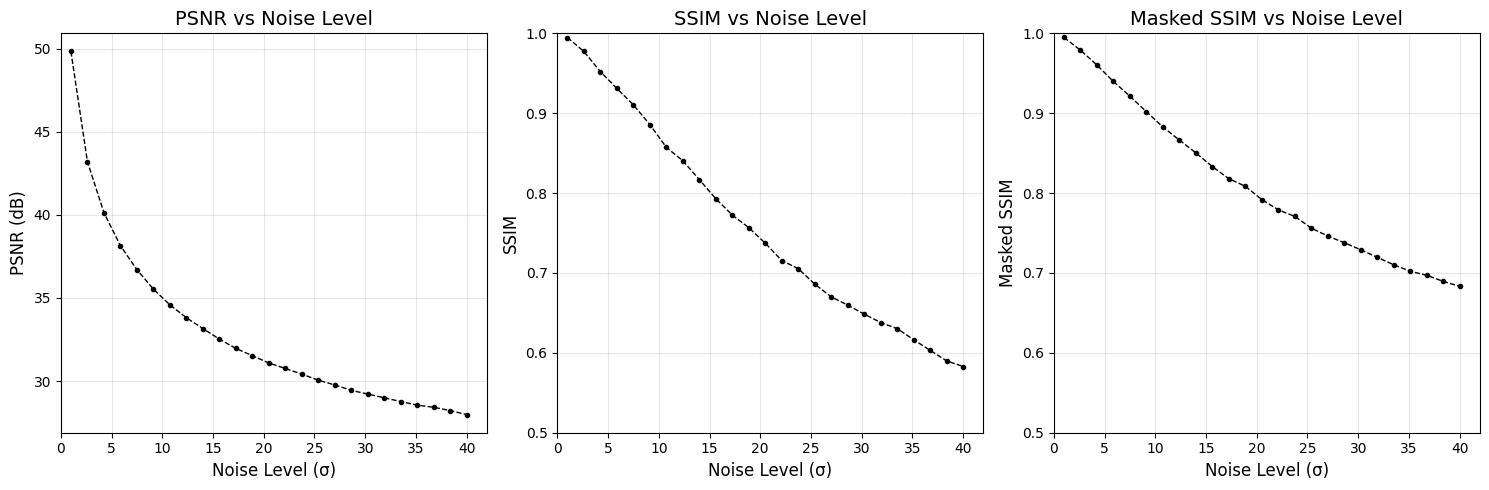


STUDY SUMMARY
Noise range tested: 1.0 - 40.0
Best PSNR: 49.82 dB (at σ=1.0)
Worst PSNR: 27.98 dB (at σ=40.0)
Best SSIM: 0.995 (at σ=1.0)
Worst SSIM: 0.583 (at σ=40.0)
Best Masked SSIM: 0.995 (at σ=1.0)
Worst Masked SSIM: 0.683 (at σ=40.0)


,noise_sigma,psnr,ssim,masked_ssim
0,1.000,49.823545,0.994754,0.994947
1,2.625,43.197753,0.977261,0.978948
2,4.250,40.132375,0.952051,0.960370
3,5.875,38.141964,0.930983,0.939713
4,7.500,36.700976,0.910475,0.921330
5,9.125,35.530986,0.885747,0.901906
6,10.750,34.584394,0.857207,0.882750
7,12.375,33.809526,0.840431,0.866427
8,14.000,33.155547,0.816819,0.850336
9,15.625,32.523057,0.792906,0.833166


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def noise_performance_study(image_path, binary_mask=None):
    """
    Study the effect of noise level on wavelet denoising performance.
    
    Parameters:
    -----------
    image_path : str
        Path to the clean test image
    binary_mask : numpy.ndarray, optional
        Binary mask for masked SSIM computation
    
    Returns:
    --------
    results_df : pandas.DataFrame
        DataFrame with noise levels and corresponding performance metrics
    """
    
    # Load clean image
    print("Loading clean image...")
    clean_img = load_image(image_path)
   
    noise_levels = np.linspace(1, 40, 25)
    
    # Initialize results storage
    results = {
        'noise_sigma': [],
        'psnr': [],
        'ssim': [],
        'masked_ssim': []
    }
    
    print("Running noise performance study...")
    print(f"Testing {len(noise_levels)} noise levels from {noise_levels[0]:.1f} to {noise_levels[-1]:.1f}")
    
    # Process each noise level
    for sigma in tqdm(noise_levels, desc="Processing noise levels"):
        try:
            # Add noise to clean image
            noisy_img = add_noise(clean_img, sigma=sigma)
            
            # Wavelet decomposition using sym4
            cA, detail_levels = wavelet_decompose(noisy_img, wavelet='dB4', level=3)
            
            # Flatten detail coefficients for threshold computation
            detail_flat = np.concatenate([coeff.ravel() for level in detail_levels for coeff in level])
            
            # Compute thresholds (we only need SURE threshold)
            T_univ, sure_threshold = compute_thresholds(detail_flat, sigma=sigma, n_points=200)
            
            # Apply soft thresholding using SURE threshold
            thresholded_details = threshold_coeffs(detail_levels, sure_threshold, mode='soft')
            
            # Reconstruct denoised image
            denoised_img = reconstruct_from_coeffs(cA, thresholded_details, wavelet='dB4')
            
            # Compute performance metrics
            psnr_score = compute_psnr(clean_img, denoised_img, max_pixel=255.0)
            ssim_score = compute_ssim(clean_img, denoised_img)
            
            # Compute masked SSIM if mask is provided
            if binary_mask is not None:
                masked_ssim_score = masked_ssim(clean_img, denoised_img, binary_mask)
            else:
                masked_ssim_score = np.nan
            
            # Store results
            results['noise_sigma'].append(sigma)
            results['psnr'].append(psnr_score)
            results['ssim'].append(ssim_score)
            results['masked_ssim'].append(masked_ssim_score)
            
        except Exception as e:
            print(f"Error processing noise level {sigma:.1f}: {str(e)}")
            # Store NaN values for failed cases
            results['noise_sigma'].append(sigma)
            results['psnr'].append(np.nan)
            results['ssim'].append(np.nan)
            results['masked_ssim'].append(np.nan)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Create and display plots
    create_performance_plots(results_df, binary_mask is not None)
    
    return results_df

def create_performance_plots(results_df, has_mask=False):
    """
    Create and display plots showing noise level vs performance metrics.
    """
    
    # Set up the plotting
    n_plots = 3 if has_mask else 2
    fig_size = (15, 5) if has_mask else (12, 5)
    
    fig, axes = plt.subplots(1, n_plots, figsize=fig_size)
    if n_plots == 2:
        axes = list(axes)
    elif n_plots == 1:
        axes = [axes]
    
    # PSNR plot
    axes[0].plot(results_df['noise_sigma'], results_df['psnr'], 'o--', linewidth=1, markersize=3, color='black')
    axes[0].set_xlabel('Noise Level (σ)', fontsize=12)
    axes[0].set_ylabel('PSNR (dB)', fontsize=12)
    axes[0].set_title('PSNR vs Noise Level', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(0, 42)
    
    # SSIM plot
    axes[1].plot(results_df['noise_sigma'], results_df['ssim'], 'o--', linewidth=1, markersize=3, color='black')
    axes[1].set_xlabel('Noise Level (σ)', fontsize=12)
    axes[1].set_ylabel('SSIM', fontsize=12)
    axes[1].set_title('SSIM vs Noise Level', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(0, 42)
    axes[1].set_ylim(0.5, 1)
    
    # Masked SSIM plot (if available)
    if has_mask:
        axes[2].plot(results_df['noise_sigma'], results_df['masked_ssim'], 'o--', linewidth=1, markersize=3, color='black')
        axes[2].set_xlabel('Noise Level (σ)', fontsize=12)
        axes[2].set_ylabel('Masked SSIM', fontsize=12)
        axes[2].set_title('Masked SSIM vs Noise Level', fontsize=14)
        axes[2].grid(True, alpha=0.3)
        axes[2].set_xlim(0, 42)
        axes[2].set_ylim(0.5, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*50)
    print("STUDY SUMMARY")
    print("="*50)
    print(f"Noise range tested: {results_df['noise_sigma'].min():.1f} - {results_df['noise_sigma'].max():.1f}")
    print(f"Best PSNR: {results_df['psnr'].max():.2f} dB (at σ={results_df.loc[results_df['psnr'].idxmax(), 'noise_sigma']:.1f})")
    print(f"Worst PSNR: {results_df['psnr'].min():.2f} dB (at σ={results_df.loc[results_df['psnr'].idxmin(), 'noise_sigma']:.1f})")
    print(f"Best SSIM: {results_df['ssim'].max():.3f} (at σ={results_df.loc[results_df['ssim'].idxmax(), 'noise_sigma']:.1f})")
    print(f"Worst SSIM: {results_df['ssim'].min():.3f} (at σ={results_df.loc[results_df['ssim'].idxmin(), 'noise_sigma']:.1f})")
    
    if has_mask:
        print(f"Best Masked SSIM: {results_df['masked_ssim'].max():.3f} (at σ={results_df.loc[results_df['masked_ssim'].idxmax(), 'noise_sigma']:.1f})")
        print(f"Worst Masked SSIM: {results_df['masked_ssim'].min():.3f} (at σ={results_df.loc[results_df['masked_ssim'].idxmin(), 'noise_sigma']:.1f})")

# Example usage:
noise_performance_study('small_image/Te-gl_0038.jpg', binary_mask=binary_mask)

Loading clean image...
Running noise performance study...
Testing 20 noise levels from 1.0 to 40.0
Comparing SURE threshold vs Universal threshold


Processing noise levels: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


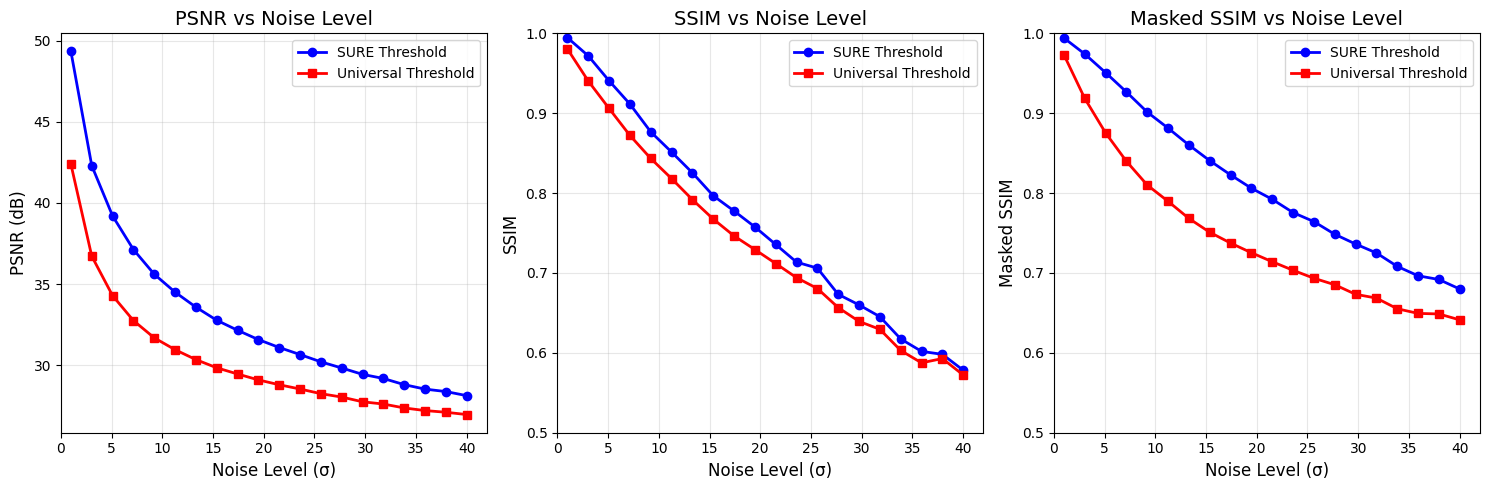


THRESHOLD COMPARISON SUMMARY
SURE Threshold Performance:
  PSNR - Mean: 33.12, Max: 49.32, Min: 28.13
  SSIM - Mean: 0.762, Max: 0.995, Min: 0.578
  Masked SSIM - Mean: 0.814, Max: 0.994, Min: 0.680

Universal Threshold Performance:
  PSNR - Mean: 30.26, Max: 42.38, Min: 26.96
  SSIM - Mean: 0.738, Max: 0.980, Min: 0.572
  Masked SSIM - Mean: 0.746, Max: 0.973, Min: 0.641

------------------------------------------------------------
OVERALL COMPARISON:
Better average PSNR: SURE
Better average SSIM: SURE
Better average Masked SSIM: SURE


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def noise_performance_study(image_path, binary_mask=None):
    """
    Study the effect of noise level on wavelet denoising performance.
    Compares SURE threshold vs Universal threshold.
    
    Parameters:
    -----------
    image_path : str
        Path to the clean test image
    binary_mask : numpy.ndarray, optional
        Binary mask for masked SSIM computation
    
    Returns:
    --------
    results_df : pandas.DataFrame
        DataFrame with noise levels and performance metrics for both threshold methods
    """
    
    # Load clean image
    print("Loading clean image...")
    clean_img = load_image(image_path)
    noise_levels = np.linspace(1, 40, 20)
    
    # Initialize results storage
    results = {
        'noise_sigma': [],
        'threshold_type': [],
        'psnr': [],
        'ssim': [],
        'masked_ssim': []
    }
    
    print("Running noise performance study...")
    print(f"Testing {len(noise_levels)} noise levels from {noise_levels[0]:.1f} to {noise_levels[-1]:.1f}")
    print("Comparing SURE threshold vs Universal threshold")
    
    # Process each noise level
    for sigma in tqdm(noise_levels, desc="Processing noise levels"):
        # Add noise to clean image
        noisy_img = add_noise(clean_img, sigma=sigma)
        
        # Wavelet decomposition using sym4
        cA, detail_levels = wavelet_decompose(noisy_img, wavelet='sym6', level=3)
        
        # Flatten detail coefficients for threshold computation
        detail_flat = np.concatenate([coeff.ravel() for level in detail_levels for coeff in level])
        
        # Compute both thresholds
        T_univ, sure_threshold = compute_thresholds(detail_flat, sigma=sigma, n_points=200)
        
        # Test both threshold types
        thresholds = {'SURE': sure_threshold, 'Universal': T_univ}
        
        for threshold_name, threshold_value in thresholds.items():
            try:
                # Apply soft thresholding
                thresholded_details = threshold_coeffs(detail_levels, threshold_value, mode='soft')
                
                # Reconstruct denoised image
                denoised_img = reconstruct_from_coeffs(cA, thresholded_details, wavelet='sym6')
                
                # Compute performance metrics
                psnr_score = compute_psnr(clean_img, denoised_img, max_pixel=255.0)
                ssim_score = compute_ssim(clean_img, denoised_img)
                
                # Compute masked SSIM if mask is provided
                if binary_mask is not None:
                    masked_ssim_score = masked_ssim(clean_img, denoised_img, binary_mask)
                else:
                    masked_ssim_score = np.nan
                
                # Store results
                results['noise_sigma'].append(sigma)
                results['threshold_type'].append(threshold_name)
                results['psnr'].append(psnr_score)
                results['ssim'].append(ssim_score)
                results['masked_ssim'].append(masked_ssim_score)
                
            except Exception as e:
                print(f"Error processing {threshold_name} threshold at noise level {sigma:.1f}: {str(e)}")
                # Store NaN values for failed cases
                results['noise_sigma'].append(sigma)
                results['threshold_type'].append(threshold_name)
                results['psnr'].append(np.nan)
                results['ssim'].append(np.nan)
                results['masked_ssim'].append(np.nan)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Create and display comparison plots
    create_comparison_plots(results_df, binary_mask is not None)
    
    return results_df

def create_comparison_plots(results_df, has_mask=False):
    """
    Create and display comparison plots showing SURE vs Universal threshold performance.
    """
    
    # Separate data for each threshold type
    sure_data = results_df[results_df['threshold_type'] == 'SURE']
    univ_data = results_df[results_df['threshold_type'] == 'Universal']
    
    # Set up the plotting
    n_plots = 3 if has_mask else 2
    fig_size = (15, 5) if has_mask else (12, 5)
    
    fig, axes = plt.subplots(1, n_plots, figsize=fig_size)
    if n_plots == 2:
        axes = list(axes)
    elif n_plots == 1:
        axes = [axes]
    
    # PSNR comparison plot
    axes[0].plot(sure_data['noise_sigma'], sure_data['psnr'], 'o-', linewidth=2, markersize=6, 
                color='blue', label='SURE Threshold')
    axes[0].plot(univ_data['noise_sigma'], univ_data['psnr'], 's-', linewidth=2, markersize=6, 
                color='red', label='Universal Threshold')
    axes[0].set_xlabel('Noise Level (σ)', fontsize=12)
    axes[0].set_ylabel('PSNR (dB)', fontsize=12)
    axes[0].set_title('PSNR vs Noise Level', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    axes[0].set_xlim(0, 42)
    
    # SSIM comparison plot
    axes[1].plot(sure_data['noise_sigma'], sure_data['ssim'], 'o-', linewidth=2, markersize=6, 
                color='blue', label='SURE Threshold')
    axes[1].plot(univ_data['noise_sigma'], univ_data['ssim'], 's-', linewidth=2, markersize=6, 
                color='red', label='Universal Threshold')
    axes[1].set_xlabel('Noise Level (σ)', fontsize=12)
    axes[1].set_ylabel('SSIM', fontsize=12)
    axes[1].set_title('SSIM vs Noise Level', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    axes[1].set_xlim(0, 42)
    axes[1].set_ylim(0.5, 1)
    
    # Masked SSIM comparison plot (if available)
    if has_mask:
        axes[2].plot(sure_data['noise_sigma'], sure_data['masked_ssim'], 'o-', linewidth=2, markersize=6, 
                    color='blue', label='SURE Threshold')
        axes[2].plot(univ_data['noise_sigma'], univ_data['masked_ssim'], 's-', linewidth=2, markersize=6, 
                    color='red', label='Universal Threshold')
        axes[2].set_xlabel('Noise Level (σ)', fontsize=12)
        axes[2].set_ylabel('Masked SSIM', fontsize=12)
        axes[2].set_title('Masked SSIM vs Noise Level', fontsize=14)
        axes[2].grid(True, alpha=0.3)
        axes[2].legend()
        axes[2].set_xlim(0, 42)
        axes[2].set_ylim(0.5, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison summary
    print("\n" + "="*60)
    print("THRESHOLD COMPARISON SUMMARY")
    print("="*60)
    
    # SURE threshold summary
    sure_summary = sure_data.groupby('threshold_type').agg({
        'psnr': ['mean', 'max', 'min'],
        'ssim': ['mean', 'max', 'min'],
        'masked_ssim': ['mean', 'max', 'min'] if has_mask else ['mean']
    }).round(3)
    
    # Universal threshold summary
    univ_summary = univ_data.groupby('threshold_type').agg({
        'psnr': ['mean', 'max', 'min'],
        'ssim': ['mean', 'max', 'min'],
        'masked_ssim': ['mean', 'max', 'min'] if has_mask else ['mean']
    }).round(3)
    
    print("SURE Threshold Performance:")
    print(f"  PSNR - Mean: {sure_data['psnr'].mean():.2f}, Max: {sure_data['psnr'].max():.2f}, Min: {sure_data['psnr'].min():.2f}")
    print(f"  SSIM - Mean: {sure_data['ssim'].mean():.3f}, Max: {sure_data['ssim'].max():.3f}, Min: {sure_data['ssim'].min():.3f}")
    if has_mask:
        print(f"  Masked SSIM - Mean: {sure_data['masked_ssim'].mean():.3f}, Max: {sure_data['masked_ssim'].max():.3f}, Min: {sure_data['masked_ssim'].min():.3f}")
    
    print("\nUniversal Threshold Performance:")
    print(f"  PSNR - Mean: {univ_data['psnr'].mean():.2f}, Max: {univ_data['psnr'].max():.2f}, Min: {univ_data['psnr'].min():.2f}")
    print(f"  SSIM - Mean: {univ_data['ssim'].mean():.3f}, Max: {univ_data['ssim'].max():.3f}, Min: {univ_data['ssim'].min():.3f}")
    if has_mask:
        print(f"  Masked SSIM - Mean: {univ_data['masked_ssim'].mean():.3f}, Max: {univ_data['masked_ssim'].max():.3f}, Min: {univ_data['masked_ssim'].min():.3f}")
    
    # Overall winner
    print(f"\n" + "-"*60)
    print("OVERALL COMPARISON:")
    print(f"Better average PSNR: {'SURE' if sure_data['psnr'].mean() > univ_data['psnr'].mean() else 'Universal'}")
    print(f"Better average SSIM: {'SURE' if sure_data['ssim'].mean() > univ_data['ssim'].mean() else 'Universal'}")
    if has_mask:
        print(f"Better average Masked SSIM: {'SURE' if sure_data['masked_ssim'].mean() > univ_data['masked_ssim'].mean() else 'Universal'}")

# Example usage:
results = noise_performance_study('small_image/Te-gl_0038.jpg', binary_mask=binary_mask)

Extra Section: 

    1. The SURE risk curve

    2. Pyramid plot

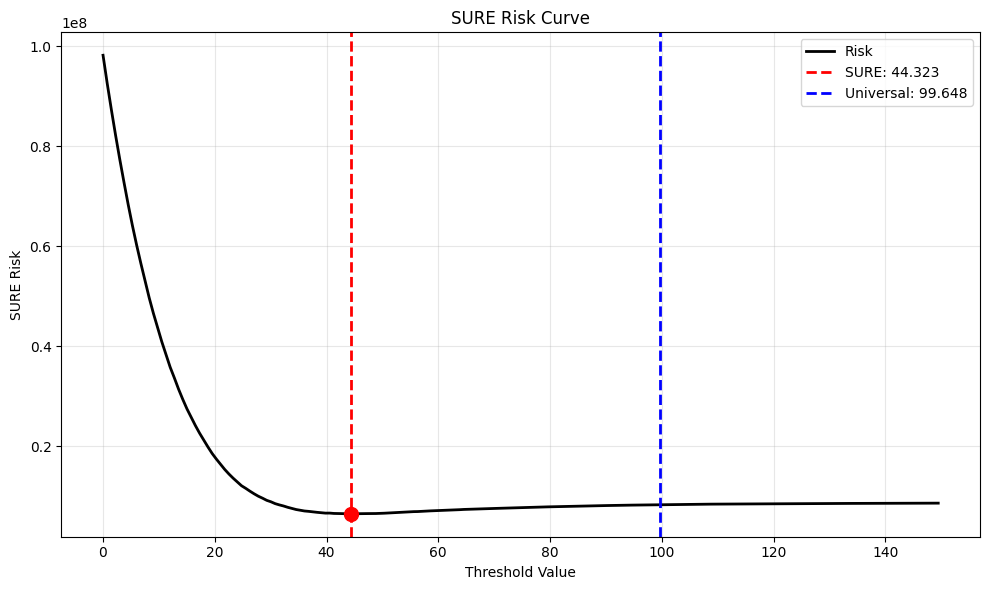

(array([1.00000000e-02, 7.61063991e-01, 1.51212798e+00, 2.26319197e+00,
        3.01425596e+00, 3.76531995e+00, 4.51638394e+00, 5.26744794e+00,
        6.01851193e+00, 6.76957592e+00, 7.52063991e+00, 8.27170390e+00,
        9.02276789e+00, 9.77383188e+00, 1.05248959e+01, 1.12759599e+01,
        1.20270239e+01, 1.27780878e+01, 1.35291518e+01, 1.42802158e+01,
        1.50312798e+01, 1.57823438e+01, 1.65334078e+01, 1.72844718e+01,
        1.80355358e+01, 1.87865998e+01, 1.95376638e+01, 2.02887278e+01,
        2.10397917e+01, 2.17908557e+01, 2.25419197e+01, 2.32929837e+01,
        2.40440477e+01, 2.47951117e+01, 2.55461757e+01, 2.62972397e+01,
        2.70483037e+01, 2.77993677e+01, 2.85504316e+01, 2.93014956e+01,
        3.00525596e+01, 3.08036236e+01, 3.15546876e+01, 3.23057516e+01,
        3.30568156e+01, 3.38078796e+01, 3.45589436e+01, 3.53100076e+01,
        3.60610716e+01, 3.68121355e+01, 3.75631995e+01, 3.83142635e+01,
        3.90653275e+01, 3.98163915e+01, 4.05674555e+01, 4.131851

In [12]:

img = load_image('small_image/Te-gl_0038.jpg')
noisy_img = add_noise(img, sigma=20)
# Wavelet decomposition
cA, detail = wavelet_decompose(noisy_img, wavelet='sym4', level=2)
all_detail_flat = np.concatenate([coeff.ravel() for level in detail for coeff in level])


def plot_sure_risk_curve(coeffs, sigma, n_points=200):
    x = coeffs.flatten()
    n = x.size
    abs_x = np.abs(x)
    
    # Universal threshold for reference
    T_univ = sigma * np.sqrt(2 * np.log(n))
    max_coeff = np.max(abs_x)
    upper_bound = max(T_univ*1.5, max_coeff*0.5)  
    thresholds = np.linspace(0.01, upper_bound, n_points)
    
    # Compute SURE risk for each threshold
    risks = []
    for t in thresholds:
        count = np.sum(abs_x <= t)
        min_terms = np.minimum(abs_x**2, t**2)
        risk = n * sigma**2 - 2 * sigma**2 * count + np.sum(min_terms)
        
        risks.append(risk)
    
    risks = np.array(risks)
    
    # Find optimal threshold
    idx_min = np.argmin(risks)
    optimal_threshold = thresholds[idx_min]
    optimal_risk = risks[idx_min]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, risks, 'black', linewidth=2, label='Risk')
    plt.axvline(optimal_threshold, color='r', linestyle='--', linewidth=2, 
                label=f'SURE: {optimal_threshold:.3f}')
    plt.axvline(T_univ, color='blue', linestyle='--', linewidth=2, 
                label=f'Universal: {T_univ:.3f}')
    plt.scatter([optimal_threshold], [optimal_risk], color='red', s=100, zorder=5)
    
    plt.xlabel('Threshold Value')
    plt.ylabel('SURE Risk')
    plt.title('SURE Risk Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)  
    plt.tight_layout()
    plt.show()
    
    return thresholds, optimal_threshold

# Plot the SURE risk curve
plot_sure_risk_curve(all_detail_flat, sigma=20, n_points=200)

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_wavelets(cA, detail_levels, wavelet='sym4', figsize=(12, 8)):
 
    n_levels = len(detail_levels)
    
    # Create grid: 1 column for approximation + 3 columns for details
    fig, axes = plt.subplots(n_levels + 1, 4, figsize=figsize)
    fig.suptitle(f'Wavelet Coefficients ({wavelet}, {n_levels} levels)', fontsize=14)
    
    if n_levels == 0:  # Single level case
        axes = axes.reshape(1, -1)
    
    # Plot approximation
    ax = axes[0, 0]
    im = ax.imshow(cA, cmap='gray')
    ax.set_title(f'Approximation Level {n_levels}')
    ax.axis('off')
    
    # Hide unused spots in first row
    for j in range(1, 4):
        axes[0, j].axis('off')
    
    # Plot details for each level
    detail_names = ['Horizontal', 'Vertical', 'Diagonal']
    
    for level_idx, (cH, cV, cD) in enumerate(detail_levels):
        row = level_idx + 1
        level_num = level_idx + 1
        
        # Skip approximation column for detail rows
        axes[row, 0].axis('off')
        
        details = [cH, cV, cD]
        for j, (detail_coeff, name) in enumerate(zip(details, detail_names)):
            ax = axes[row, j + 1]
            im = ax.imshow(detail_coeff, cmap='RdBu_r')
            ax.set_title(f'{name} Level {level_num}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_multilevel_wavelet(cA, details, n_levels):
    """
    Create a single image showing multilevel wavelet decomposition
    in the standard wavelet display format
    """
    # Get the size from the approximation coefficients
    h, w = cA.shape
    
    # Calculate output size (should match original image size)
    # Each level doubles the size, so work backwards
    output_h = h * (2 ** n_levels)
    output_w = w * (2 ** n_levels)
    
    # Initialize output image
    output = np.zeros((output_h, output_w))
    
    # Place approximation coefficients in top-left
    output[0:h, 0:w] = cA
    
    # Place detail coefficients for each level
    curr_h, curr_w = h, w
    
    for level in range(n_levels):
        # Get detail coefficients for this level (from finest to coarsest)
        cH, cV, cD = details[n_levels - 1 - level]
        
        # Place horizontal details (top-right of current block)
        output[0:curr_h, curr_w:curr_w*2] = cH
        
        # Place vertical details (bottom-left of current block) 
        output[curr_h:curr_h*2, 0:curr_w] = cV
        
        # Place diagonal details (bottom-right of current block)
        output[curr_h:curr_h*2, curr_w:curr_w*2] = cD
        
        # Double the size for next level
        curr_h *= 2
        curr_w *= 2
    
    return output

def plot_wavelet_reconstruction(cA, details, wavelet='sym4', figsize=(12, 5)):
    """
    Plot both the multilevel decomposition and individual components
    """
    n_levels = len(details)
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Left plot: Multilevel wavelet display
    wavelet_display = plot_multilevel_wavelet(cA, details, n_levels)
    
    ax = axes[0]
    im1 = ax.imshow(wavelet_display, cmap='gray')
    ax.set_title(f'Multilevel Wavelet Display\n({wavelet}, {n_levels} levels)')
    ax.axis('off')
    plt.colorbar(im1, ax=ax, shrink=0.8)
    
    # Right plot: Approximation only
    ax = axes[1]
    im2 = ax.imshow(cA, cmap='gray')
    ax.set_title(f'Approximation Coefficients\n(Level {n_levels})')
    ax.axis('off')
    plt.colorbar(im2, ax=ax, shrink=0.8)
    
    plt.tight_layout()
    plt.show()
    

    return wavelet_display



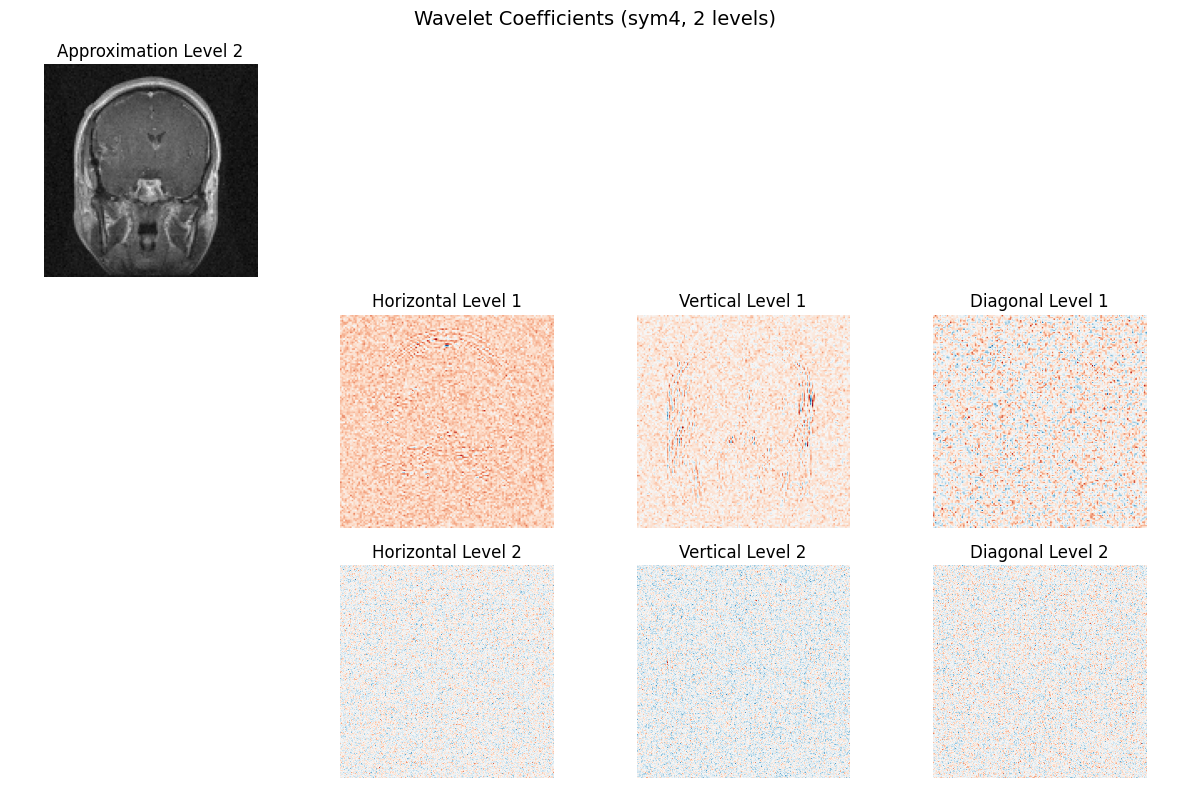

In [14]:
plot_wavelets(cA, detail, wavelet='sym4', figsize=(12, 8))